In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import pickle

import warnings
warnings.filterwarnings("ignore")

# Data Reading 

In [2]:
df = pd.read_csv ('Telco_Customer_Churn.csv')
df.info()

df2 = df.drop(["customerID","StreamingMovies"],axis=1)

for col in df2.columns:
    print("========================")
    print(df2[col].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
modify_cols = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV"]

for col in modify_cols:
    df2[col] = df2[col].replace({"No internet service":"No"})
    
df2["MultipleLines"] = df2["MultipleLines"].replace({"No phone service":"No"})

In [4]:
total_charges_col = df2[['TotalCharges']].replace(" ",None)

df2["TotalCharges"] = total_charges_col
df2["TotalCharges"] = df2["TotalCharges"].astype(float)

df2 = df2.dropna()

# Visualization

<AxesSubplot:ylabel='Churn'>

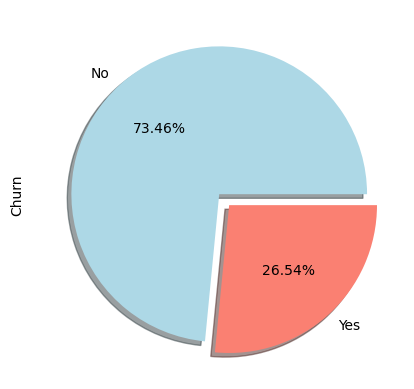

In [5]:
df["Churn"].value_counts().plot(kind="pie",colors=["lightblue","salmon"],explode = (0, 0.1),shadow=True,autopct='%1.2f%%')

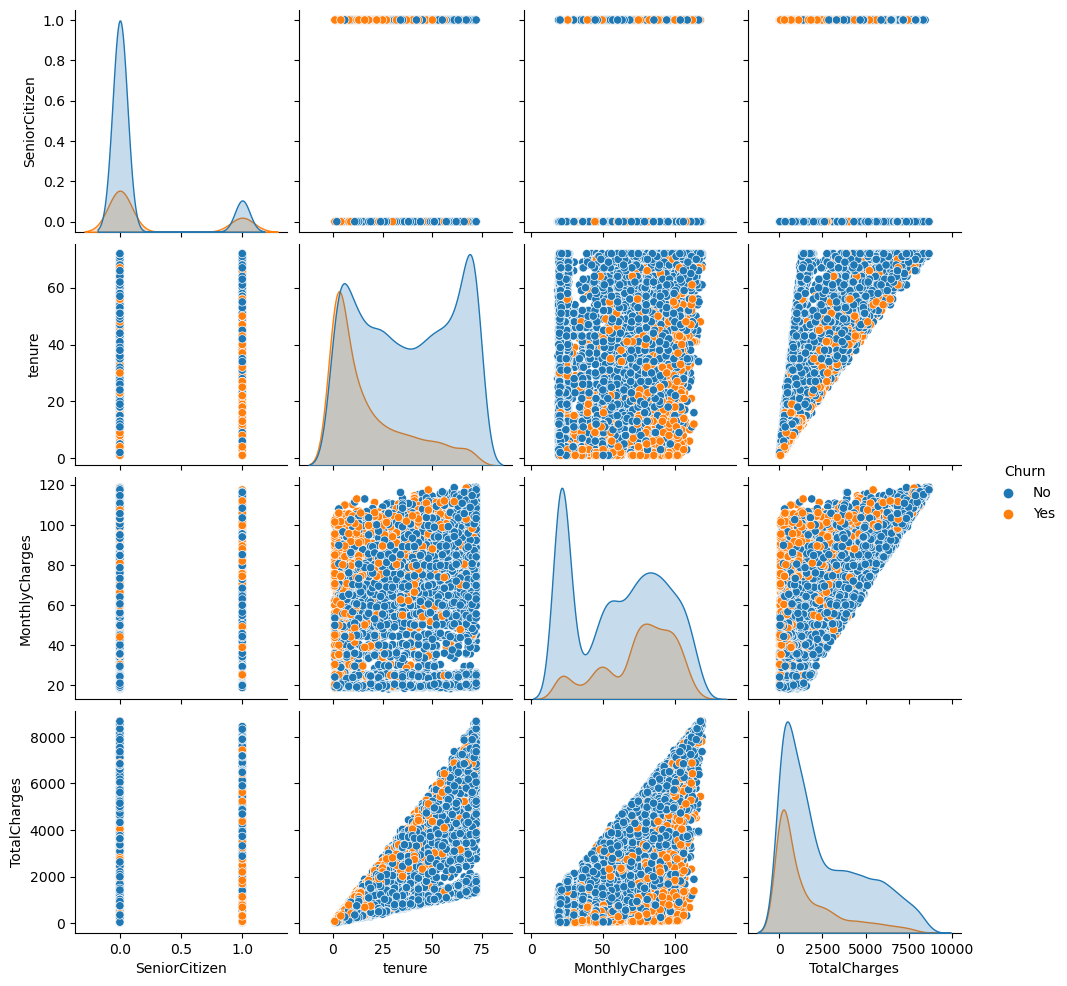

In [6]:
sns.pairplot(df2,hue="Churn")
plt.show()

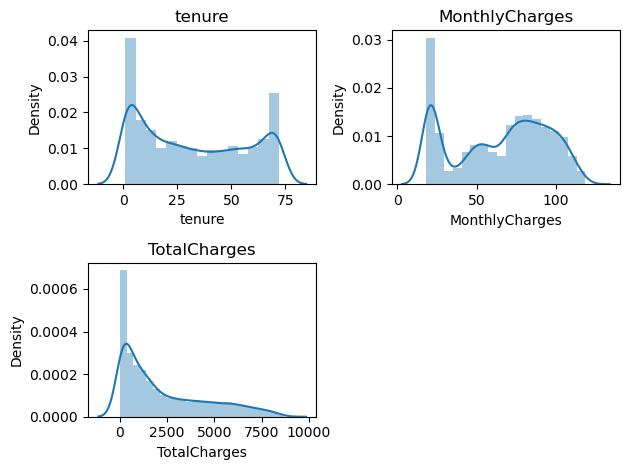

In [7]:
# distribution
cols = ["tenure","MonthlyCharges","TotalCharges"]
for i in range(len(cols)):
    plt.subplot(2,2,i+1)
    sns.distplot(df2[cols[i]])
    plt.title(cols[i])
plt.tight_layout()

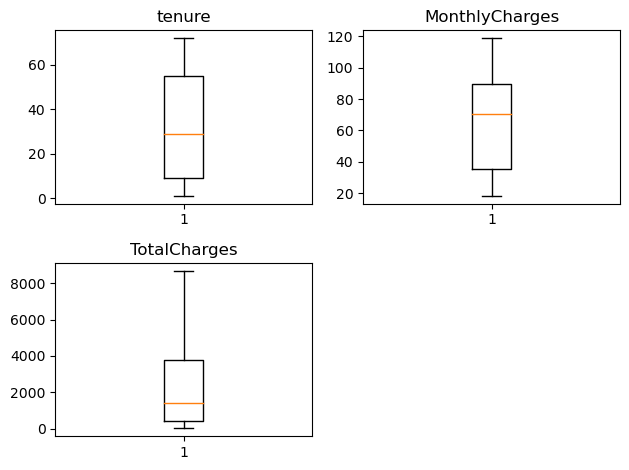

In [8]:
# outliers
cols = ["tenure","MonthlyCharges","TotalCharges"]
for i in range(len(cols)):
    plt.subplot(2,2,i+1)
    plt.boxplot(df2[cols[i]])
    plt.title(cols[i])
plt.tight_layout()

# Data Preparation

In [9]:
df2 = pd.get_dummies(data=df2,columns=["gender","Partner","Dependents","PhoneService","MultipleLines","InternetService",\
                                       "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV",\
                                       "PaperlessBilling","PaymentMethod"],drop_first=True)

In [10]:
ord_encoder = OrdinalEncoder(categories=[["Month-to-month","One year","Two year"]])
encoded_contract = ord_encoder.fit_transform(df2[["Contract"]])
df2["Contract"] = encoded_contract

In [11]:
lbl_encoder = LabelEncoder()
encoded_lbls = lbl_encoder.fit_transform(df2["Churn"])
df2["Churn"] = encoded_lbls

print("Yes  No", lbl_encoder.transform(["Yes","No"]) )

Yes  No [1 0]


In [12]:
y = df2["Churn"]
X = df2.drop("Churn",axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print(X_train.shape)
print(X_test.shape)

(5625, 21)
(1407, 21)


In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
cols_to_scale = ["tenure","MonthlyCharges","TotalCharges"]
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale]) 
# X_test

In [14]:
X_train.head(3)

,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,...,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2964,0,0.323944,1.0,0.399005,0.153254,1,1,0,1,1,...,0,1,0,0,1,0,1,0,1,0
5113,0,0.985915,2.0,0.949254,0.940226,0,1,1,1,1,...,0,1,1,1,1,1,0,1,0,0
5363,0,0.971831,2.0,0.070647,0.195748,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,1


In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 2964 to 2737
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          5625 non-null   int64  
 1   tenure                                 5625 non-null   float64
 2   Contract                               5625 non-null   float64
 3   MonthlyCharges                         5625 non-null   float64
 4   TotalCharges                           5625 non-null   float64
 5   gender_Male                            5625 non-null   uint8  
 6   Partner_Yes                            5625 non-null   uint8  
 7   Dependents_Yes                         5625 non-null   uint8  
 8   PhoneService_Yes                       5625 non-null   uint8  
 9   MultipleLines_Yes                      5625 non-null   uint8  
 10  InternetService_Fiber optic            5625 non-null   uint8  
 11  I

## Trying three models :
### 1) Naive Bayes
### 2) Decision Tree Classifier
### 3) QDA

In [16]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train,y_train)
pred1 = nb_model.predict(X_test)
s1 = nb_model.score(X_train,y_train)
f1 = f1_score(y_test,pred1)
r1 = recall_score(y_test,pred1)
print("NB score ",s1)
print("NB f1_score ",f1)
print("NB recall ",r1)
print("==================================================")

# Decision tree
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train,y_train)
pred2 = dt_model.predict(X_test)
s2 = dt_model.score(X_train,y_train)
f2 = f1_score(y_test,pred2)
r2 = recall_score(y_test,pred2)
print("DT score ",s2)
print("DT f1_score ",f2)
print("DT recall",r2)
print("==================================================")

# QDA
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train,y_train)
pred3 = qda_model.predict(X_test)
s3 = qda_model.score(X_train,y_train)
f3 = f1_score(y_test,pred3)
r3 = recall_score(y_test,pred3)
print("QDA score ",s3)
print("QDA f1_score ",f3)
print("QDA recall",r3)

NB score  0.7587555555555555
NB f1_score  0.6064659977703456
NB recall  0.7371273712737128
DT score  0.9978666666666667
DT f1_score  0.4913678618857902
DT recall 0.5013550135501355
QDA score  0.7704888888888889
QDA f1_score  0.5961754780652417
QDA recall 0.7181571815718157


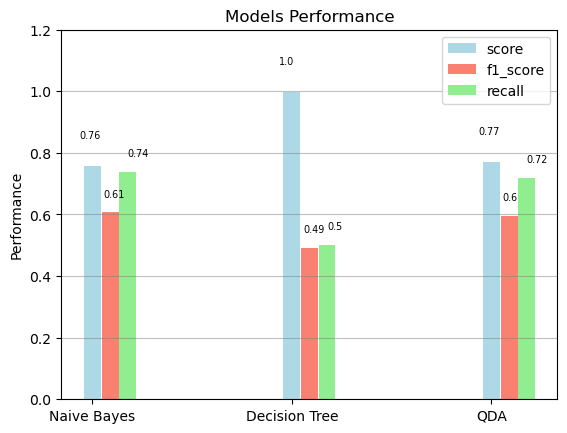

In [17]:
# plotting results
xaxis = np.array([1,4,7])
y1 = np.array([s1,s2,s3])
y2 = np.array([f1,f2,f3])
y3 = np.array([r1,r2,r3])

plt.bar(xaxis,y1,width=0.25,color="lightblue",label="score")
plt.bar(xaxis+0.27,y2,width=0.25,color="salmon",label="f1_score")
plt.bar(xaxis+0.53,y3,width=0.25,color="lightgreen",label="recall")


plt.xticks(xaxis,["Naive Bayes","Decision Tree","QDA"])

for i in range(3):
    plt.text(xaxis[i]-0.2,y1[i]+0.09,np.round(y1[i],2),fontsize="x-small")
    
for i in range(3):
    plt.text(xaxis[i]+0.17,y2[i]+0.05,np.round(y2[i],2),fontsize="x-small")
    
for i in range(3):
    plt.text(xaxis[i]+0.53,y3[i]+0.05,np.round(y3[i],2),fontsize="x-small")
    
    

plt.title("Models Performance")
plt.ylabel("Performance")
plt.ylim([0, 1.2])
plt.legend(loc="best")
plt.grid(color='gray',axis="y",alpha=0.5)
plt.show()

## Over Sampling 

In [18]:
o_lbl = y_train[y_train == 1].shape
z_lbl = y_train[y_train == 0].shape

In [19]:
ov_sampler = SMOTE(sampling_strategy = 'not majority', random_state=0)
X_train_ov,y_train_ov = ov_sampler.fit_resample(X_train,y_train)

In [20]:
nb = GaussianNB()
dt = DecisionTreeClassifier(random_state=0)
qda = QuadraticDiscriminantAnalysis()

In [21]:
# Naive Bayes
nb.fit(X_train_ov,y_train_ov)
pred4 = nb.predict(X_test)

s4 = nb.score(X_train_ov,y_train_ov)
f4 = f1_score(y_test,pred4)
r4 = recall_score(y_test,pred4)

print("NB score (over sampling) ",s4)
print("NB f1_score (over sampling)",f4)
print("NB recall (over sampling) ",r4)
print("==================================================")

# Decision Tree
dt.fit(X_train_ov,y_train_ov)
pred5 = dt.predict(X_test)

s5 = dt.score(X_train_ov,y_train_ov)
f5 = f1_score(y_test,pred5)
r5 = recall_score(y_test,pred5)

print("RF score (over sampling) ",s5)
print("RF f1_score (over sampling)",f5)
print("RF recall (over sampling) ",r5)
print("==================================================")

#QDA
qda.fit(X_train_ov,y_train_ov)
pred6 = qda.predict(X_test)

s6 = qda.score(X_train_ov,y_train_ov)
f6 = f1_score(y_test,pred6)
r6 = recall_score(y_test,pred6)

print("QDA score (over sampling) ",s6)
print("QDA f1_score (over sampling)",f6)
print("QDA recall (over sampling) ",r6)

NB score (over sampling)  0.7710303030303031
NB f1_score (over sampling) 0.5978260869565216
NB recall (over sampling)  0.7452574525745257
RF score (over sampling)  0.9985454545454545
RF f1_score (over sampling) 0.5152625152625152
RF recall (over sampling)  0.5718157181571816
QDA score (over sampling)  0.7865454545454545
QDA f1_score (over sampling) 0.5967567567567568
QDA recall (over sampling)  0.7479674796747967


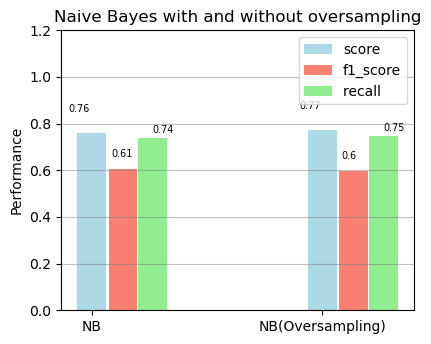

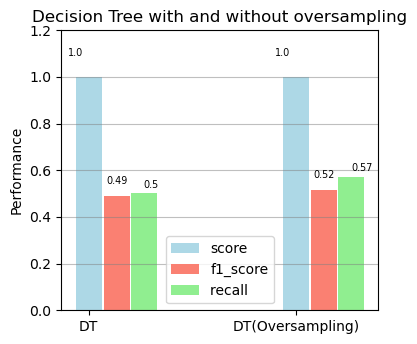

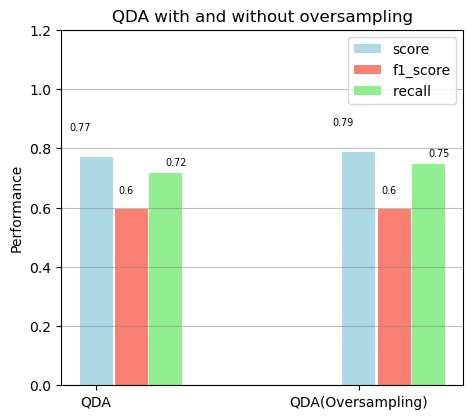

In [22]:
# plotting results
xaxis2 = np.array([1,3])
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
y11 = np.array([s1,s4])
y22 = np.array([f1,f4])
y33 = np.array([r1,r4])

plt.bar(xaxis2,y11,width=0.25,color="lightblue",label="score")
plt.bar(xaxis2+0.27,y22,width=0.25,color="salmon",label="f1_score")
plt.bar(xaxis2+0.53,y33,width=0.25,color="lightgreen",label="recall ")

plt.xticks(xaxis2,["NB","NB(Oversampling)"])

for i in range(2):
    plt.text(xaxis2[i]-0.2,y11[i]+0.09,np.round(y11[i],2),fontsize="x-small")
    
for i in range(2):
    plt.text(xaxis2[i]+0.17,y22[i]+0.05,np.round(y22[i],2),fontsize="x-small")
    
for i in range(2):
    plt.text(xaxis2[i]+0.53,y33[i]+0.025,np.round(y33[i],2),fontsize="x-small")

plt.title("Naive Bayes with and without oversampling")
plt.ylabel("Performance")
plt.ylim([0, 1.2])
plt.legend(loc="best")
plt.grid(color='gray',axis="y",alpha=0.5)
plt.show()

#################################################################################################
plt.figure(figsize=(9,8))
plt.subplot(2,2,2)
y11 = np.array([s2,s5])
y22 = np.array([f2,f5])
y33 = np.array([r2,r5])

plt.bar(xaxis2,y11,width=0.25,color="lightblue",label="score")
plt.bar(xaxis2+0.27,y22,width=0.25,color="salmon",label="f1_score")
plt.bar(xaxis2+0.53,y33,width=0.25,color="lightgreen",label="recall ")

plt.xticks(xaxis2,["DT","DT(Oversampling)"])

for i in range(2):
    plt.text(xaxis2[i]-0.2,y11[i]+0.09,np.round(y11[i],2),fontsize="x-small")
    
for i in range(2):
    plt.text(xaxis2[i]+0.17,y22[i]+0.05,np.round(y22[i],2),fontsize="x-small")
    
for i in range(2):
    plt.text(xaxis2[i]+0.53,y33[i]+0.025,np.round(y33[i],2),fontsize="x-small")

plt.title("Decision Tree with and without oversampling")
plt.ylabel("Performance")
plt.ylim([0, 1.2])
plt.legend(loc="best")
plt.grid(color='gray',axis="y",alpha=0.5)

#################################################################################################
plt.figure(figsize=(9,8))
plt.subplot(2,2,3)
y11 = np.array([s3,s6])
y22 = np.array([f3,f6])
y33 = np.array([r3,r6])

plt.bar(xaxis2,y11,width=0.25,color="lightblue",label="score")
plt.bar(xaxis2+0.27,y22,width=0.25,color="salmon",label="f1_score")
plt.bar(xaxis2+0.53,y33,width=0.25,color="lightgreen",label="recall ")

plt.xticks(xaxis2,["QDA","QDA(Oversampling)"])

for i in range(2):
    plt.text(xaxis2[i]-0.2,y11[i]+0.09,np.round(y11[i],2),fontsize="x-small")
    
for i in range(2):
    plt.text(xaxis2[i]+0.17,y22[i]+0.05,np.round(y22[i],2),fontsize="x-small")
    
for i in range(2):
    plt.text(xaxis2[i]+0.53,y33[i]+0.025,np.round(y33[i],2),fontsize="x-small")

plt.title("QDA with and without oversampling")
plt.ylabel("Performance")
plt.ylim([0, 1.2])
plt.legend(loc="best")
plt.grid(color='gray',axis="y",alpha=0.5)

plt.tight_layout()
plt.show()

In [23]:
# trying the KNN (experminting)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_ov,y_train_ov)
pred7 = knn_model.predict(X_test)

s7 = knn_model.score(X_train_ov,y_train_ov)
f7 = f1_score(y_test,pred7)
r7 = recall_score(y_test,pred7)

print("KNN score (over sampling) ",s7)
print("KNN f1_score (over sampling)",f7)
print("KNN recall (over sampling) ",r7)

KNN score (over sampling)  0.8621818181818182
KNN f1_score (over sampling) 0.5609492988133764
KNN recall (over sampling)  0.7046070460704607


# Feature Selection

In [24]:
print("features before selection : ",X_train_ov.shape)

features before selection :  (8250, 21)


In [41]:
# SelectFromModel
rfc = RandomForestClassifier(n_estimators=20,random_state=0)
selector = SelectFromModel(estimator=rfc)
selected_train = selector.fit_transform(X_train_ov,y_train_ov)

print("features after selection (SelectFromModel): ",selected_train.shape,"\n ")

dt2 = DecisionTreeClassifier(random_state=0)
dt2.fit(selected_train,y_train_ov)
pred8 = dt2.predict(selector.transform(X_test))

s8 = dt2.score(selected_train,y_train_ov)
f8 = f1_score(y_test,pred8)
r8 = recall_score(y_test,pred8)

print("DT score (feature selection) ",s8)
print("DT f1_score (feature selection)",f8)
print("DT recall (feature selection) ",r8)
print("==============================================")

knn2 = KNeighborsClassifier()
knn2.fit(selected_train,y_train_ov)
pred9 = knn2.predict(selector.transform(X_test))

s9 = knn2.score(selected_train,y_train_ov)
f9 = f1_score(y_test,pred9)
r9 = recall_score(y_test,pred9)

print("KNN score (feature selection) ",s9)
print("KNN f1_score (feature selection)",f9)
print("KNN recall (feature selection) ",r9)
print("==============================================")


nb2 = GaussianNB()
nb2.fit(selected_train,y_train_ov)
pred10 = nb2.predict(selector.transform(X_test))

s10 = nb2.score(selected_train,y_train_ov)
f10 = f1_score(y_test,pred10)
r10 = recall_score(y_test,pred10)

print("NB score (feature selection ",s10)
print("NB f1_score (feature selection)",f10)
print("NB recall (feature selection) ",r10)
print("==============================================")

qda2 = QuadraticDiscriminantAnalysis()
qda2.fit(selected_train,y_train_ov)
pred11 = qda2.predict(selector.transform(X_test))

s11 = qda2.score(selected_train,y_train_ov)
f11 = f1_score(y_test,pred11)
r11 = recall_score(y_test,pred11)

print("QDA score (feature selection ",s11)
print("QDA f1_score (feature selection)",f11)
print("QDA recall (feature selection) ",r11)

features after selection (SelectFromModel):  (8250, 5) 
 
DT score (feature selection)  0.9930909090909091
DT f1_score (feature selection) 0.5172413793103449
DT recall (feature selection)  0.5691056910569106
KNN score (feature selection)  0.8415757575757575
KNN f1_score (feature selection) 0.5950226244343891
KNN recall (feature selection)  0.7127371273712737
NB score (feature selection  0.7471515151515151
NB f1_score (feature selection) 0.577570093457944
NB recall (feature selection)  0.8373983739837398
QDA score (feature selection  0.7526060606060606
QDA f1_score (feature selection) 0.5849056603773585
QDA recall (feature selection)  0.8401084010840109


In [42]:
# features that were selected by the selector
selector.get_feature_names_out()

array(['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges',
       'InternetService_Fiber optic'], dtype=object)

In [43]:
# maaking the code re-usable for other data
models = [dt2,knn2,nb2,qda2]
recall_scores = [r8,r9,r10,r11]

max_score = recall_scores[0]
final_model = models[0]

for i in range(len(recall_scores)) :
    if recall_scores[i] > max_score :
        max_score = recall_scores[i]
        final_model = models[i]

print("final model is : ",final_model)
print("recall score : ",max_score)

final model is :  QuadraticDiscriminantAnalysis()
recall score :  0.8401084010840109


In [44]:
# saving the model 
with open("model.pkl","wb") as model_file :
    pickle.dump(final_model,model_file)
print("model saved !")

model saved !


In [45]:
# saving the selector
with open("selector.pkl","wb") as selector_file :
    pickle.dump(selector,selector_file)
print("selector saved !")

selector saved !


In [46]:
# saving the scaler
with open("scaler.pkl","wb") as scaler_file :
    pickle.dump(scaler,scaler_file)
print("scaler saved !")

scaler saved !
